<a href="https://colab.research.google.com/github/BabalpreetK/vigilant-octo-goggles/blob/main/Copy_of_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adversarial-robustness-toolbox torch torchvision matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

# Define transformations
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Load MNIST dataset
train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.98MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
import torch.nn as nn

class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the size after convolutions and pooling
        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self):
        # Pass a dummy tensor to calculate the flattened size
        dummy_input = torch.zeros(1, 1, 28, 28)
        x = self.pool(torch.relu(self.conv2(torch.relu(self.conv1(dummy_input)))))
        return x.numel()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch.optim as optim

# Initialize model, loss, and optimizer
model = AdvancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10  # Set higher epochs for better accuracy

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")


Epoch 1/10, Loss: 0.18415689077188593
Epoch 2/10, Loss: 0.04649020994562648
Epoch 3/10, Loss: 0.028136516591833867
Epoch 4/10, Loss: 0.018408995271394297
Epoch 5/10, Loss: 0.013102677557046518
Epoch 6/10, Loss: 0.010101833919427846
Epoch 7/10, Loss: 0.00813671352238077
Epoch 8/10, Loss: 0.007067698652629923
Epoch 9/10, Loss: 0.006167322070799087
Epoch 10/10, Loss: 0.005217211905382506


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy on test dataset: {100 * correct / total:.2f}%")


Accuracy on test dataset: 98.96%


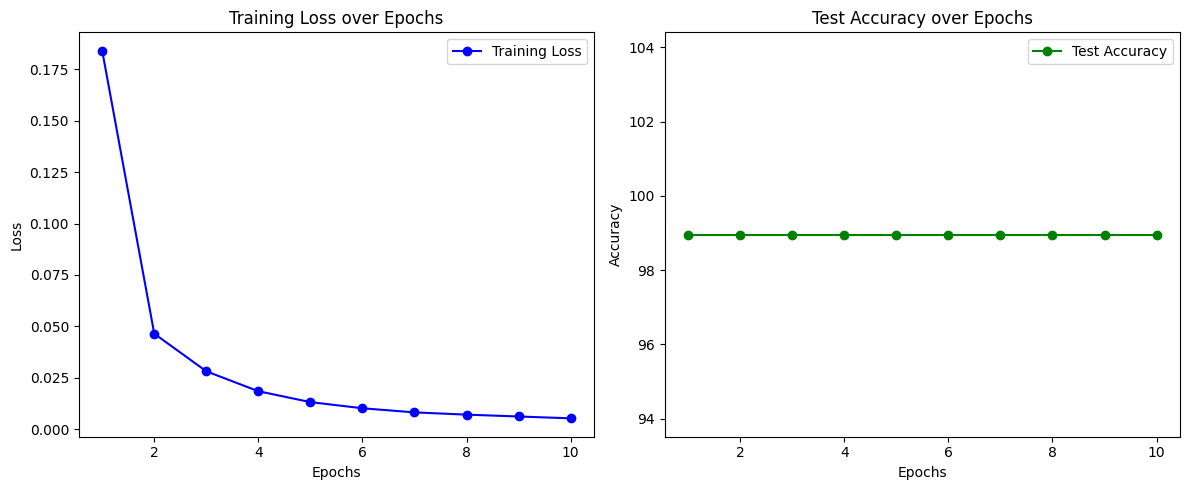

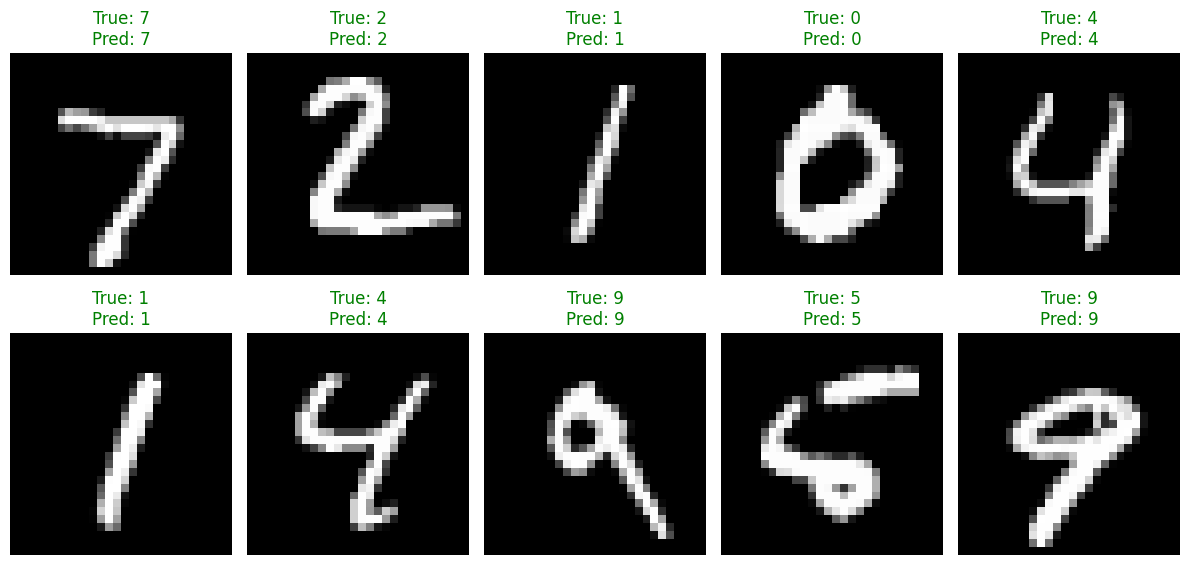

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training loss and test accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'g-o', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize some test predictions
def visualize_predictions(model, test_loader, classes):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    # Show a few images with predictions
    fig = plt.figure(figsize=(12, 6))
    for i in range(10):  # Display first 10 images
        ax = fig.add_subplot(2, 5, i + 1)
        img = images[i].squeeze(0).numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predictions[i]]}",
                     color='green' if labels[i] == predictions[i] else 'red')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage after training
train_losses = [0.1841, 0.0464, 0.0281, 0.0184, 0.0131, 0.0101, 0.0081, 0.0070, 0.0061, 0.0052]  # Replace with actual losses
test_accuracies = [98.96] * 10  # Replace with actual accuracies if tracked

plot_metrics(train_losses, test_accuracies)
visualize_predictions(model, test_loader, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])


In [ ]:
import torch

# FGSM attack function
def fgsm_attack(model, image, label, epsilon=0.1):
    # Set model to evaluation mode
    model.eval()

    # Set requires_grad to True for the image tensor
    image.requires_grad = True

    # Forward pass
    output = model(image)
    loss = criterion(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Backpropagate to get gradients of loss w.r.t. image
    loss.backward()

    # Collect the gradient of the image
    image_grad = image.grad.data

    # Create the adversarial image by adjusting the image in the direction of the gradient
    adversarial_image = image + epsilon * image_grad.sign()

    # Clamp the image to be in the valid range
    adversarial_image = torch.clamp(adversarial_image, 0, 1)

    return adversarial_image


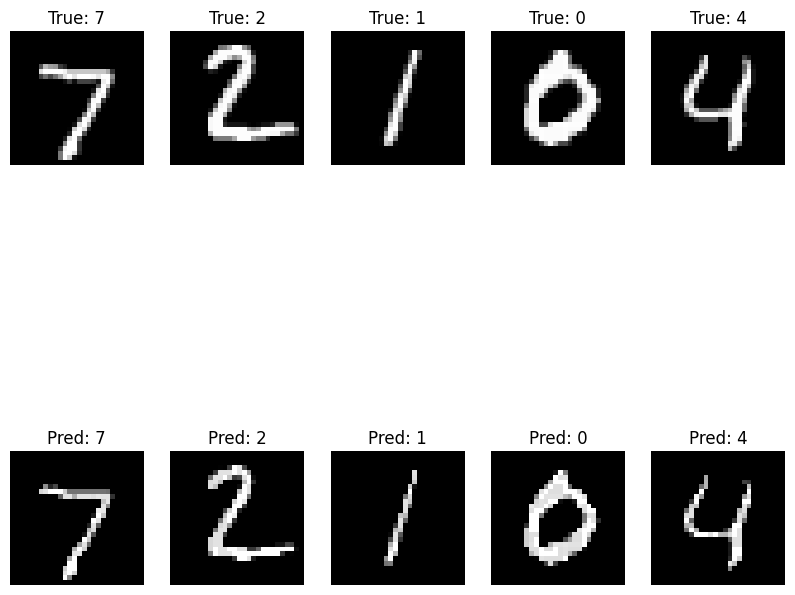

Accuracy on adversarial examples: 88.06%


In [ ]:
import torch
import matplotlib.pyplot as plt

# FGSM attack function
def fgsm_attack(model, image, label, epsilon=0.1):
    model.eval()  # Set model to evaluation mode
    image.requires_grad = True  # Set requires_grad to True for image tensor

    # Forward pass
    output = model(image)
    loss = criterion(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Backpropagate to get gradients of loss w.r.t. image
    loss.backward()

    # Collect the gradient of the image
    image_grad = image.grad.data

    # Create the adversarial image by adjusting the image in the direction of the gradient
    adversarial_image = image + epsilon * image_grad.sign()

    # Clamp the image to be in the valid range
    adversarial_image = torch.clamp(adversarial_image, 0, 1)

    return adversarial_image

# Generate adversarial examples
num_samples = 5
images, labels = next(iter(test_loader))  # Fetch a batch of images and labels

# Create adversarial examples
adversarial_images = fgsm_attack(model, images, labels, epsilon=0.1)

# Plot original and adversarial images with predicted and true labels
plt.figure(figsize=(10, 10))

for i in range(num_samples):
    # Original Image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')  # Detach tensor from graph
    plt.title(f'True: {labels[i].item()}')
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_samples, i+1+num_samples)
    plt.imshow(adversarial_images[i].detach().cpu().numpy().squeeze(), cmap='gray')  # Detach tensor from graph
    plt.title(f'Pred: {model(adversarial_images[i:i+1]).argmax().item()}')
    plt.axis('off')

plt.show()

# Evaluate the model on adversarial examples
correct = 0
total = 0
for images, labels in test_loader:
    adversarial_images = fgsm_attack(model, images, labels, epsilon=0.1)
    outputs = model(adversarial_images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

adversarial_accuracy = 100 * correct / total
print(f'Accuracy on adversarial examples: {adversarial_accuracy:.2f}%')


In [ ]:
def feature_squeezing(image, squeeze_factor=2):
    # Squeeze the feature by reducing the bit-depth (round to nearest integer)
    squeezed_image = image.clone()
    squeezed_image = (squeezed_image * squeeze_factor).round() / squeeze_factor
    return squeezed_image


In [ ]:
# Feature Squeezing + Adversarial Attack
def evaluate_with_defense(model, test_loader, epsilon=0.1, squeeze_factor=2):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Apply Feature Squeezing to the images
        squeezed_images = feature_squeezing(images, squeeze_factor)

        # Generate adversarial examples from the squeezed images
        adversarial_images = fgsm_attack(model, squeezed_images, labels, epsilon)

        # Forward pass with adversarial images
        outputs = model(adversarial_images)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f'Accuracy on adversarial examples with feature squeezing: {accuracy:.2f}%')

# Run the evaluation with defense
evaluate_with_defense(model, test_loader)


Accuracy on adversarial examples with feature squeezing: 88.52%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the same architecture as your target model (Net)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)  # Updated size
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 output classes (e.g., for MNIST)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor dynamically based on the computed size
        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Step 1: Train a surrogate model (attacker's model)
def train_surrogate_model(train_loader):
    surrogate_model = Net()  # Same model architecture as the target model
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=0.001)

    for epoch in range(10):
        surrogate_model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Surrogate Model Epoch {epoch+1}/10, Loss: {running_loss/len(train_loader)}")

    return surrogate_model

# Step 2: Generate adversarial examples using the surrogate model
def generate_adversarial_examples_surrogate(surrogate_model, images, labels, epsilon=0.1):
    surrogate_model.eval()
    images.requires_grad = True
    output = surrogate_model(images)
    loss = criterion(output, labels)

    surrogate_model.zero_grad()
    loss.backward()
    image_grad = images.grad.data
    adversarial_images = images + epsilon * image_grad.sign()
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Step 3: Evaluate the target model on adversarial examples generated by the surrogate
def evaluate_black_box_attack(target_model, surrogate_model, test_loader, epsilon=0.1):
    target_model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        adversarial_images = generate_adversarial_examples_surrogate(surrogate_model, images, labels, epsilon)
        outputs = target_model(adversarial_images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on black-box attack examples: {accuracy:.2f}%")

# Train surrogate model
surrogate_model = train_surrogate_model(train_loader)

# Evaluate target model using black-box attack
evaluate_black_box_attack(model, surrogate_model, test_loader)


Surrogate Model Epoch 1/10, Loss: 0.2199270779421843
Surrogate Model Epoch 2/10, Loss: 0.04945910558986193
Surrogate Model Epoch 3/10, Loss: 0.03445853983149626
Surrogate Model Epoch 4/10, Loss: 0.026757428437463447
Surrogate Model Epoch 5/10, Loss: 0.020015457358364182
Surrogate Model Epoch 6/10, Loss: 0.016917935254718505
Surrogate Model Epoch 7/10, Loss: 0.015050063337343855
Surrogate Model Epoch 8/10, Loss: 0.014564925330354205
Surrogate Model Epoch 9/10, Loss: 0.009494309015824015
Surrogate Model Epoch 10/10, Loss: 0.010284525951123493
Accuracy on black-box attack examples: 90.88%
